# Wedgex

Use an analytical solution for particle trajectories in an orogenic wedge, use the particle depths to calculate thermochronometer cooling ages and compare to thermochronology data. 


## Wokflow:

* This notebook can be used to run a single model and show the calculated particle trajectories, exhumation rates and thermochronology ages. 
* In addition, there is an option to calibrate the model, i.e. let the model find the parameter values that provides the best fit to thermochronology data. For this one needs to set `calibrate_parameters = True` and uncomment and adjust the `params_to_change` and `params` variables, see the examples below.
* It also optionally runs a series of models to explore the model fit for a range of parameter combinations. To run the parameter exploration set the parameter `parameter_space_search = True` in the box with the header Parameter space search, and adjust the values for vd_range, vc_range, vxa_range and vya_range.

The default parameters and data are based on the Kuru Chu cross-section in the Himalayas, a well studied cross section which was explored Long et al. (2012, https://doi.org/10.1029/2012TC003155), Coutand et al. (2014, https://doi.org/10.1002/2013JB010891) and McQuarrie and Ehlers (2015, https://doi.org/10.1002/2014TC003783).

The thermochronology data that are used are located in the file [data/thermochron_data_projected.csv](data/thermochron_data_projected.csv). This file was created by a separate notebook [utilities/extract_xsection_data.ipynb](utilities/extract_xsection_data.ipynb), which automatically extracts thermochronology data along a cross-section.

## Import modules

In [1]:
import string
import itertools
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

import sklearn.metrics

import scipy.optimize

# equations for particle trajectories
import wedgeqs

# function wrappers to run multiple models and compare modelled and measured thermochron ages
import wedgex_model_functions

In [2]:
pl.rcParams['mathtext.default'] = 'regular'

In [3]:
from cmcrameri import cm
cmap = cm.batlow

## Filenames

In [4]:
# name of file with thermochron data
thermochron_data_file = 'data/thermochron_data_projected.csv'

# column with distance
distance_column = 'projected_distance_along_xsection'
thermochronometer_col = 'system'

# filename for output file with modelled ages thermochron samples
thermochron_output_file = 'data/modelled_thermochron_data.csv'

# output file with modelled ages vs distance
thermochron_profile_file = 'data/modelled_thermochron_profiles.csv'

## Model parameters

In [5]:
model_run_name = 'default'

# compressional, transport and accretion velocity
vc = -5e-3
vd = -5e-3
vxa = 0.0
vya = 0.0

# option to calibrate parameters or to run the model with default parameters
calibrate_parameters = False

# parameters to optimize and starting values 
#model_run_name = 'calibrated'
#params_to_change = ['vc', 'vd', 'vxa', 'vya']
#params = [-3e-3, -3e-3, 1e-5, 1e-5]

#model_run_name = 'detachment_cal'
#params_to_change = ['vd']
#params = [-3e-3]

#model_run_name = 'compression_cal'
#params_to_change = ['vc']
#params = [-3e-3]

#model_run_name = 'accretion_cal'
#params_to_change = ['vxa', 'vya']
#params = [1e-5, 1e-5]

# lenght of wedge (m)
L = 200e3

# slope of topography (m/m)
# for McQuarrie & Ehlers: ~ 4km over 117 km 
alpha = 0.034

# slope of bottom of wedge (m/m)
# for McQuarrie & Ehlers: detachment depth at N edge xsection (117 km) = ~20 km
beta = -0.17

# disctance between surface points (m)
x_interval = 5e3

x_first_pt = 1e3

# number of rows in the orogenic wedge. Used for figures only, no function in the actual model
n_rows = 100

# modelled timespan (years)
max_time = 2e8

# timestep size (years)
dt = 1e4

# names of thermochronometers, should match the names in your input file
thermochron_systems = ['AHe', 'AFT', 'ZHe', 'ZFT', 'MAr']

# resetting temperatures (degr. C)
resetting_temperatures = [70.0, 110.0, 180.0, 230.0, 325.0]

# default exhumation rate, used to calculate ages from the undeformed foreland 
# that have not been reset inside the wedge (m/yr)
default_exhumation_rate = 1e-4

# option to remove non-reset ages from database
remove_non_reset_ages = True

# limit for estimating which ages are reset or not (Ma)
reset_age_limit =  100.0

# geothermal gradient, used to convert resetting temp to depth (degr. C/m)
geothermal_gradient = 0.015

# surface temperature at sea lvl (degr. C)
surface_temperature_sea_lvl = 24.0

# adiabatic lapse rate (C/m), used to calculate surface temperatures
lapse_rate = 7.0 / 1e3

## Additional model calibration options

In [6]:
# metric to calibrate the models. use 'MAE' or 'chisq'
calibration_metric = 'MAE'

# limit parameters to realistic limits
# if True the model will limit vc <= 0, vd <= 0, vxa >= 0, vya >=0
limit_params = True

# convergence criteria for optimization algorithm
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html for more info
xtol = 1e-8
ftol = 1e-8

## Options for figures

In [7]:
# figure size, in inches:
fig_width = 170 / 25.4
#fig_width = 140 / 25.4
fig_height = 0.75

# subplot label start, 0 = a
first_subplot = 2

# add legend
add_legend = True

# add
add_equation = False

# show each x particle paths in figure
starting_pt_int = 4

# isochrons to show
isochrons = np.arange(0, 55, 5)

# some figure options
fig_output_file = 'fig/wedgex_model_%s' % model_run_name
fig_formats = ['png', 'pdf', 'svg']

thermochron_markers = ['o', 'd', 's', '^', 'h']
thermochron_colors = ['darkblue', 'blue', 'green', 'red', 'orange']

# isochrons to show in figure:
isochrons = [5e6, 10e6, 15e6, 20e6, 25e6]

# maximum thermochron age on y-axis
max_age_fig = 20.0

# log scale for cooling ages:
log_scale_ages = False

fs = 'x-small'

gr = 1.618033

# draw flow arrows for one in x particle locations
arrow_int = 250

# scale for flow arrows. higher means smaller arrows
scale = 2.0

## Set up initial particle positions and timesteps

In [8]:
# x-coordinates of starting points:
x0s = np.arange(0, L + x_interval, x_interval)
x0s[0] = x_first_pt

# timesteps (years)
t = np.arange(0, -max_time - dt, -dt)

print('particle starting points (m from tip of wedge):\n', x0s)

print('timesteps (yr):\n', t / 1e6)

particle starting points (m from tip of wedge):
 [  1000.   5000.  10000.  15000.  20000.  25000.  30000.  35000.  40000.
  45000.  50000.  55000.  60000.  65000.  70000.  75000.  80000.  85000.
  90000.  95000. 100000. 105000. 110000. 115000. 120000. 125000. 130000.
 135000. 140000. 145000. 150000. 155000. 160000. 165000. 170000. 175000.
 180000. 185000. 190000. 195000. 200000.]
timesteps (yr):
 [ 0.0000e+00 -1.0000e-02 -2.0000e-02 ... -1.9998e+02 -1.9999e+02
 -2.0000e+02]


## Determine isochrons to show in figures

i.e., get the timesteps for the different timeslices that are defined by the variable isochrons

In [9]:
isochron_ts = [np.argmin(np.abs(t - ic)) for ic in isochrons]

## Load thermochron data

In [10]:
df = pd.read_csv(thermochron_data_file)

print('thermochron data systems in file: ', df[thermochronometer_col].unique())

thermochron data systems in file:  ['ZHe' 'AFT' 'MAr']


## Remove anomalously old ages

In [11]:
if remove_non_reset_ages is True:

    print('ages before removing non-resset ages:\n', df['age'].describe())
    
    df = df[df['age'] < reset_age_limit]
    
    print('ages after removing non-resset ages:\n', df['age'].describe())

count      48.000000
mean       56.973812
std       245.686577
min         2.700000
25%         4.222500
50%         6.930000
75%         8.940000
max      1395.700000
Name: age, dtype: float64
count    46.000000
mean      6.915935
std       2.913004
min       2.700000
25%       4.207500
50%       6.600000
75%       8.615000
max      14.780000
Name: age, dtype: float64


## Calculate resetting temperatures for samples

In [12]:
# get sample positions from dataframe
x0_samples = df[distance_column].values

df['resetting_temp'] = np.nan

for thc, rt in zip(thermochron_systems, resetting_temperatures):
    
    ix = df[thermochronometer_col] == thc 
    df.loc[ix, 'resetting_temp'] = rt

# calculate surface temperature
df['surface_T'] = surface_temperature_sea_lvl - lapse_rate * df['elevation']
df['resetting_depth'] = (df['resetting_temp'] - df['surface_T']) / geothermal_gradient

#df.head()

## Parameter calibration

In [13]:
measured_ages = df['age'].values
measured_ages_sigma = df['age_error_1s'].values
resetting_temperatures_samples = df['resetting_temp'].values

if calibrate_parameters is True:

    args = (params_to_change, limit_params, t, x0_samples, alpha, beta, L, vc, vd, vxa, vya, 
            surface_temperature_sea_lvl, lapse_rate, geothermal_gradient,
            measured_ages, measured_ages_sigma, resetting_temperatures_samples, default_exhumation_rate,
            calibration_metric)
    
    print('using %s metric to calibrate model ' % calibration_metric)
    
    print('starting optimization, this may take a while....')
    opt_results = scipy.optimize.fmin(wedgex_model_functions.compare_modelled_and_measured_ages, 
                                      params, args=args, 
                                      maxiter=1e5, xtol=xtol, ftol=ftol, full_output=True)

    print('done optimizing')
    params = opt_results[0]
    opt_error = opt_results[1]

    print('optimized parameter values ', params)
    print('optimized model error ', opt_error)
    
    # update parameters with calibrated values
    if 'alpha' in params_to_change:
        alpha = params[params_to_change.index('alpha')]
    if 'beta' in params_to_change:
        beta = params[params_to_change.index('beta')]
    if 'geothermal_gradient' in params_to_change:
        geothermal_gradient = params[params_to_change.index('geothermal_gradient')]
    if 'vc' in params_to_change:
        vc = params[params_to_change.index('vc')]
    if 'vd' in params_to_change:
        vd = params[params_to_change.index('vd')]
    if 'vxa' in params_to_change:
        vxa = params[params_to_change.index('vxa')]
    if 'vya' in params_to_change:
        vya = params[params_to_change.index('vya')]
    
    if limit_params is True:
        # enforce same conditions as imposed during optimization
        # make sure params have correct sign
        # negative for vc, vd and positive for vxa, vya
        if vc >= 0:
            vc = -1e-7
        if vd >= 0:
            vd = -1e-7
        if vxa < 0:
            vxa = 0
        if vya <0:
            vya = 0
#else:
#    params = 

## Rerun model with optimized or default parameters

(depending on whether calibrate_parameters was True or False)

In [14]:
if calibrate_parameters is True:
    comp_output = wedgex_model_functions.compare_modelled_and_measured_ages(
        params, params_to_change, limit_params, t, x0_samples, 
        alpha, beta, L, vc, vd, vxa, vya, 
        surface_temperature_sea_lvl, lapse_rate, geothermal_gradient,
        measured_ages, measured_ages_sigma, resetting_temperatures_samples,
        default_exhumation_rate, metric_to_return='all',
        return_all=True)

    (y0_samples_check, x_samples_check, y_samples_check, 
     resetting_temperatures_samples_check, d_samples_check, 
     data_check, prediction_check, ME_check, MAE_check, R2_check) = comp_output

## Get particle trajectories and ages with optimized params for all seed points in model domain

In [15]:
from importlib import reload

wedgex_model_functions = reload(wedgex_model_functions)


# particle trajectories 
xp, yp, dp = wedgex_model_functions.run_model_multiple_samples(t, x0s, 
                                                               alpha, beta, L, 
                                                               vc, vd, vxa, vya)

y0p = xp * alpha

# model ages for entire model domain
modelled_ages_all = np.zeros((len(xp), len(thermochron_systems)))

for i, tc in enumerate(thermochron_systems):
    
    res_temp_pts = np.ones_like(x0s) * resetting_temperatures[i]
    modelled_ages_all[:, i] = wedgex_model_functions.calculate_cooling_ages(
        t, xp, dp, alpha, res_temp_pts, 
        surface_temperature_sea_lvl, lapse_rate, geothermal_gradient, default_exhumation_rate, L)


## Get particle trajectories and ages with optimized params for all samples

In [16]:
x_samples, y_samples, d_samples = wedgex_model_functions.run_model_multiple_samples(t, x0_samples, 
                                                             alpha, beta, L, 
                                                             vc, vd, vxa, vya)

y0_samples = x_samples * alpha

modelled_ages_samples  = wedgex_model_functions.calculate_cooling_ages(t, x_samples, d_samples, alpha, 
                                                resetting_temperatures_samples, 
                                                     surface_temperature_sea_lvl, lapse_rate, 
                                                     geothermal_gradient, default_exhumation_rate, L)

## Calculate model fit

In [17]:
data = measured_ages
prediction = modelled_ages_samples

ind_nok = (np.isnan(data)) | (np.isnan(prediction))

data = data[ind_nok==False]
prediction = prediction[ind_nok==False]
unc_adj = measured_ages_sigma[ind_nok==False]

ME = np.mean(data - prediction)
MAE = sklearn.metrics.mean_absolute_error(data, prediction)
R2 = sklearn.metrics.r2_score(data, prediction)

misfit_ind = (data - prediction)**2 / (unc_adj**2)

misfit = wedgex_model_functions.misfit_function(data, unc_adj, prediction)

print('mean error of this model run = %0.3f\n'
      'mean absolute error %0.3f\n'
      'coefficient of determination = %0.3f\n'
      'misfit = %0.3f' % (ME, MAE, R2, misfit))

mean error of this model run = 0.371
mean absolute error 1.182
coefficient of determination = 0.745
misfit = 0.980


## Calculate exhumation rate

In [19]:
dd = np.diff(dp, axis=1)
exhumation_rate = dd[:, 0] / (t[0] - t[1])

## Make a figure

/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


saving figure as fig/wedgex_model_default.png
saving figure as fig/wedgex_model_default.pdf
saving figure as fig/wedgex_model_default.svg


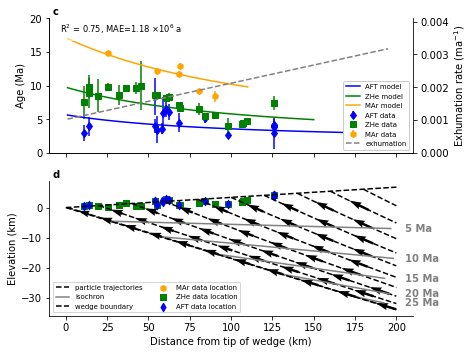

In [20]:
xcoords = np.linspace(0, L, 101)
y_top = xcoords * alpha
y_bottom = xcoords * beta

xpi, ypi = xp, yp
dpi = dp

legs = []
labels = []

fig, axs = pl.subplots(2, 1, figsize=(fig_width, fig_width * fig_height), sharex=True)

#############################
# panel with thermochron ages
#############################
for i, thc, c in zip(itertools.count(), thermochron_systems,  thermochron_colors):
    if thc in df[thermochronometer_col].values:
        lt, = axs[0].plot(x0s / 1e3, modelled_ages_all[:, i], color=c)
        legs.append(lt)
        labels.append('%s model' % thc)
        
for thc, m, c in zip(thermochron_systems, thermochron_markers, thermochron_colors):
    
    ix = df[thermochronometer_col] == thc
    
    if np.any(ix) == True:
        #axs[0].scatter(df.loc[ix, distance_column] / 1e3, df.loc[ix, 'age'], 
        # label='%s data' % thc, color=c, marker=m)
        
        x = df.loc[ix, distance_column] / 1e3
        z = df.loc[ix, 'age']
        ze = df.loc[ix, 'age_error_1s'] * 2
        sc = axs[0].errorbar(x, z, yerr=ze, ls='None', color=c, marker=m)
        legs.append(sc)
        labels.append('%s data' % thc)

#
if log_scale_ages is True:
    axs[0].set_yscale('log')    
else:
    axs[0].set_ylim(0, max_age_fig)
axs[0].set_ylabel('Age (Ma)')

tekst = r'$R^2$ = %0.2f, MAE=%0.2f $\times 10^6$ a' % (R2, MAE)
if add_equation is True:
    tekst += '\n'
    tekst += '$v_c$=%0.1e, $v_d$=%0.1e, $v_{xa}$=%0.1e ,$v_{ya}$=%0.1e ' \
                % (vc, vd, vxa, vya)
txt = axs[0].text(0.03, 0.97, tekst, transform=axs[0].transAxes, 
                  ha='left', va='top', fontsize='small')
txt.set_bbox(dict(facecolor='white', alpha=0.5, color='white'))

################################
# 2nd axis with exhumation rate
################################
axr = axs[0].twinx()

le, = axr.plot(xp[:, 0] / 1e3, exhumation_rate, color='gray', ls='--')
legs.append(le)
labels.append('exhumation')
axr.set_ylabel(r'Exhumation rate ($m a^{-1}$)')
axr.set_ylim(0, axr.get_ylim()[-1] * 1.25)

if add_legend is True:
    axs[0].legend(legs, labels, fontsize=fs, loc='lower right', facecolor='white', framealpha=1)

#######################
# particle trajectories
#######################

ax = axs[-1]

ind = xpi > L
xpi[ind] = np.nan
ypi[ind] = np.nan

for xl, yl in zip(xpi[::starting_pt_int], ypi[::starting_pt_int]):
    leg_traj, = ax.plot(xl / 1e3, yl / 1e3, ls='--', color='black')
    
    x, y = xl[::-arrow_int] / 1e3, yl[::-arrow_int] / 1e3
    U, V = x[1:]-x[:-1], y[1:]-y[:-1]
    #U = U / np.sqrt(U**2 + V**2)
    #V = V / np.sqrt(U**2 + V**2)
    leg_qv = ax.quiver(x[:-1], y[:-1], U, V, 
                        scale_units='xy', angles='xy', scale=scale)

nt = xpi.shape[1]

if isochrons is None:
    isochron_ts = np.linspace(0, nt - 1, 5).astype(int)
else:
    isochron_ts = [np.argmin(np.abs(-t - chron)) for chron in isochrons]

for i, nti in enumerate(isochron_ts):
    #leg_ts =  ax.scatter(xpi[:, nti] / 1e3, ypi[:, nti] / 1e3, s=20, color='black')
    leg_tsl, =  ax.plot(xpi[:, nti] / 1e3, ypi[:, nti] / 1e3, color='gray', ls='-', lw=1.5)
    
    tekst = '%0.0f Ma' % (isochrons[i] / 1e6)
    text_buffer = 5
    xt, yt = xpi[:, nti] / 1e3 + text_buffer, ypi[:, nti] / 1e3
    ind = (np.isnan(xt) == False) & (np.isnan(yt) == False)
    
    if np.any(ind):
        txt = ax.text(L / 1e3 + text_buffer, yt[ind][-1], tekst, 
                      ha='left', va='center', weight='bold', color='gray')
        #txt.set_bbox(dict(facecolor='white', alpha=0.5, color='white'))
    pass

legs_tc = []
labels_tc = []

for thc, m, c in zip(thermochron_systems[::-1], thermochron_markers[::-1], thermochron_colors[::-1]):
    
    ix = df[thermochronometer_col] == thc
        
    if np.any(ix) == True:
        labels_tc.append('%s data location' % thc)
        li = ax.scatter(df.loc[ix, distance_column] / 1e3, df.loc[ix, 'elevation'] / 1e3, 
                        color=c, marker=m)
        legs_tc.append(li)
        
#leg_s = ax.scatter(df['distance'], df['elevation'] / 1e3, label='thermochron samples')

leg_bnd, = ax.plot(xcoords / 1e3, y_top / 1e3, color='black', ls='--', lw=1.5)
ax.plot(xcoords / 1e3, y_bottom / 1e3, color='black', ls='--', lw=1.5)

ax.set_xlabel('Distance from tip of wedge (km)')
ax.set_ylabel('Elevation (km)')

for i, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.01, 1.01, string.ascii_lowercase[i + first_subplot], 
            weight='bold', transform=ax.transAxes, 
               ha='left', va='bottom', fontsize='medium')

axr.spines['top'].set_visible(False)

if add_legend is True:
    legs = [leg_traj, leg_tsl, leg_bnd] + legs_tc
    labels = ['particle trajectories', 'isochron', 'wedge boundary'] + labels_tc
    axs[-1].legend(legs, labels, loc='lower left', ncol=2, fontsize=fs)

fig.tight_layout()

for f in fig_formats:
    fn = fig_output_file + '.' + f
    print('saving figure as %s' % fn)
    fig.savefig(fn)

## Read published results

In [21]:
fnds = ['data/AFT.txt', 'data/ZHe.txt', 'data/MAr.txt']

dfts = [pd.read_csv(fn, delimiter='\t') for fn in fnds]

thermochron_syst_published = ['AFT', 'ZHe', 'MAr']

# correction for distance vs xsection, McQuarrie (2015) xsection does not start at the MFT
distance_correction = 2.0

# correction for sample positioning, somehow the xsection in mcquarrie and Ehlers seems squeezed. projection issue?
dist_corr_factor = 1.13

## Calculate model statistics for published results

In [22]:
measured_ages = df['age'].values
x0_samples = df[distance_column].values

for i, thc in zip(itertools.count(), thermochron_systems):
    if thc in thermochron_syst_published:
        
        # get modelled ages for this particular system
        j = thermochron_syst_published.index(thc)
        dft = dfts[j]
        xms = (dft['x'].values - distance_correction) * dist_corr_factor
        modelled_ages = dft['y'].values
        
        # get modelled ages for each measured age
        ind = df['system'] == thc
        
        xs = df.loc[ind, distance_column].values / 1000.0
        
        age_modelled_samples = np.interp(xs, xms, modelled_ages)
        df.loc[ind, 'modelled_ages_published'] = age_modelled_samples

dfi = df[['age', 'modelled_ages_published']].dropna()
data_pub, pred_pub = dfi['age'].values, dfi['modelled_ages_published'].values
R2_pub = sklearn.metrics.r2_score(data_pub, pred_pub)
MAE_pub = sklearn.metrics.mean_absolute_error(data_pub, pred_pub)

print(f'model fit published models: R2 = {R2_pub:.2f}, MAE = {MAE_pub:.1f} Ma')

model fit published models: R2 = -0.43, MAE = 2.5 Ma


/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


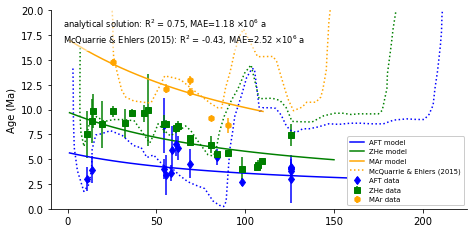

In [23]:
legs = []
labels = []

fig, ax = pl.subplots(1, 1, figsize=(fig_width, fig_width /2.0))

#############################
# panel with thermochron ages
#############################
lp = None
for i, thc, c in zip(itertools.count(), thermochron_systems,  thermochron_colors):
    if thc in df[thermochronometer_col].values:
        lt, = ax.plot(x0s / 1e3, modelled_ages_all[:, i], color=c)
        legs.append(lt)
        labels.append('%s model' % thc)
        
        if thc in thermochron_syst_published:
            j = thermochron_syst_published.index(thc)
            
            dft = dfts[j]
            x = (dft['x'] - distance_correction) * dist_corr_factor
            age = dft['y']
            
            lp, = ax.plot(x, age, color=c, ls=':')
            
if lp is not None:           
    legs.append(lp)
    labels.append('McQuarrie & Ehlers (2015)')
        
        
for thc, m, c in zip(thermochron_systems, thermochron_markers, thermochron_colors):
    
    ix = df[thermochronometer_col] == thc
    
    if np.any(ix) == True:
        #axs[0].scatter(df.loc[ix, distance_column] / 1e3, df.loc[ix, 'age'], 
        # label='%s data' % thc, color=c, marker=m)
        
        x = df.loc[ix, distance_column] / 1e3
        z = df.loc[ix, 'age']
        ze = df.loc[ix, 'age_error_1s'] * 2
        sc = ax.errorbar(x, z, yerr=ze, ls='None', color=c, marker=m)
        legs.append(sc)
        labels.append('%s data' % thc)

#
if log_scale_ages is True:
    ax.set_yscale('log')    
else:
    ax.set_ylim(0, max_age_fig)
ax.set_ylabel('Age (Ma)')

tekst = r'analytical solution: $R^2$ = %0.2f, MAE=%0.2f $\times 10^6$ a' % (R2, MAE)
tekst += '\n'
tekst += r'McQuarrie & Ehlers (2015): $R^2$ = %0.2f, MAE=%0.2f $\times 10^6$ a' % (R2_pub, MAE_pub)
txt = ax.text(0.03, 0.97, tekst, transform=ax.transAxes, 
                  ha='left', va='top', fontsize='small')
txt.set_bbox(dict(facecolor='white', alpha=0.5, color='white'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(legs, labels, fontsize=fs, loc='lower right', facecolor='white', framealpha=1)

fig.tight_layout()

fig.savefig('fig/comparison_mcquarrie2015.pdf')
fig.savefig('fig/comparison_mcquarrie2015.png')



## Parameter space search

Use the box below to switch parameter space search on or off. Note that this can be quite time consuming

In [24]:
parameter_space_search = False

## Define parameter ranges for the parameter search

In [25]:
#vc_range = np.linspace(-1e-3, -20e-3, n_ints)
#vd_range = np.linspace(-1e-3, -10e-3, n_ints)
multipliers = np.array([1/2, 2/3., 1.0, 3/2, 2.])
additions = np.arange(-4e-3, 5e-3, 1e-3)

additions2 = np.arange(-2e-3, 3e-3, 1e-3)
additions3 = np.arange(-2e-4, 3e-4, 1e-4)

vc_range =  vc + additions
vd_range =  vd + additions

#vxa_range = np.linspace(0, 1e-3, n_ints)
#vya_range = np.linspace(0.0, 1e-3, n_ints)
vxa_range = vxa + additions2
vya_range = vya + additions3

vc_range = vc_range[vc_range < 0] 
vd_range = vd_range[vd_range < 0]

vxa_range = vxa_range[vxa_range >= 0]
vya_range = vya_range[vya_range >= 0]

## The actual parameter space search

In [26]:
if parameter_space_search is True:
    
    metric_to_return = 'R2'
    
    n_ints = 5

    scenario_parameter_list = [vc_range, vd_range, vxa_range, vya_range]

    param_combs = list(itertools.product(*scenario_parameter_list))

    print('testing %i parameter combinations' % len(param_combs))
    print('this may take some time')

    error_stats_all = []

    nc = len(param_combs)

    for i, p in enumerate(param_combs):

        if nc > 100 and float(i / 100) == int(i / 100):
            print('parameter combination %i of %i' % (i+1, nc))

        error_stats = wedgex_model_functions.compare_modelled_and_measured_ages(
            p, params_to_change, limit_params, t, x0_samples, 
             alpha, beta, L, vc, vd, vxa, vya, 
             surface_temperature_sea_lvl, 
             lapse_rate, geothermal_gradient,
             measured_ages, measured_ages_sigma, resetting_temperatures_samples,
             default_exhumation_rate,
             metric_to_return)
        
       # params_to_change, limit_params, t, x0_samples, alpha, beta, L, vc, vd, vxa, vya, 
       #     surface_temperature_sea_lvl, lapse_rate, geothermal_gradient,
       #     measured_ages, measured_ages_sigma, resetting_temperatures_samples, default_exhumation_rate,
       #     calibration_metric
        
        error_stats_all.append(error_stats)

    print('done testing parameter combinations')

In [27]:
if parameter_space_search is True:
    param_combs_array = np.array(param_combs)
    model_errors = np.array(error_stats_all)

## Make a figure of parameter space search 

In [28]:
def unique_rows(a):
    """
    remove duplicate rows from an array

    found on stackoverflow:
    http://stackoverflow.com/questions/8560440/
    removing-duplicate-columns-and-rows-from-a-numpy-2d-array

    :param a:
    :return:
    """
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))

    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

if parameter_space_search is True:
    z = model_errors[:]

    vmin = 0.0
    vmax = 1.0

    param_combs_plots = [[0, 1], [2, 3]]

    ax_labels = [[r'$v_c \; (m\;s^{-1})$', r'$v_d \; (m\;s^{-1})$'], 
                 [r'$v_{xa} \; (m\;s^{-1})$', r'$v_{ya} \; (m\;s^{-1})$']]

    fig, axs = pl.subplots(1, 2, figsize=(8, 4))

    for ax, pc, al in zip(axs, param_combs_plots, ax_labels):

        # get min error for each overlapping pt:
        v1 = param_combs_array[:, pc[0]]
        v2 = param_combs_array[:, pc[1]]
        a = np.vstack([v1, v2]).T
        ur = unique_rows(a)

        zs = np.zeros(len(ur))

        for i, ui in enumerate(ur):
            ind = (a[:, 0] == ui[0]) & (a[:, 1] == ui[1])
            zs[i] = np.max(z[ind])


        sc = ax.scatter(ur[:, 0], ur[:, 1], c=zs,
                   vmin=vmin, vmax=vmax, s=100, cmap=cmap)

        ax.set_xlabel(al[0])
        ax.set_ylabel(al[1])

    fig.subplots_adjust(bottom=0.32, wspace=0.5)

    cax = fig.add_axes([0.25, 0.12, 0.5, 0.02])

    cb = fig.colorbar(sc, cax=cax, orientation='horizontal')
    cb.set_label(r'$R^2$')

    for i, ax in enumerate(axs):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.text(0.01, 1.01, string.ascii_lowercase[i], 
                weight='bold', transform=ax.transAxes, 
                   ha='left', va='bottom', fontsize='medium')

    #fig.tight_layout()

    fig.savefig('fig/parameter_space_exp.png')
    fig.savefig('fig/parameter_space_exp.pdf')
